In [14]:
#https://medium.com/towards-formula-1-analysis/how-i-analyze-formula-1-data-with-python-2021-italian-gp-dfb11db4b73

In [76]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.image as image
from skimage.transform import resize
import numpy as np
import pandas as pd

In [77]:
# Enable the cache
ff1.Cache.enable_cache('cache') 

# Setup plotting
#plotting.setup_mpl()
ff1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=False)

In [78]:

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [81]:
# Solicitar variables
year = int(input('Año: '))
wknd = int(input('Round: '))
print('------ Session Type ------')
print('R - Race')
print('Q - Qualifying')
print('SQ - Sprint Qualifying')
print('FP1 - Practice 1')
print('FP2 - Practice 2')
print('FP3 - Practice 3')
print('--------------------------')
ses = input('Session :')
driver1 = input('Piloto 1: ')
driver2 = input('Piloto 2: ')

Año: 2021
Round: 14
------ Session Type ------
R - Race
Q - Qualifying
SQ - Sprint Qualifying
FP1 - Practice 1
FP2 - Practice 2
FP3 - Practice 3
--------------------------
Session :R
Piloto 1: RIC
Piloto 2: VER


In [82]:
# Load the session data
session = ff1.get_session(year, wknd, ses)

# Get the laps
laps = session.load(telemetry=True)

core           INFO 	Loading data for Italian Grand Prix - Race [v2.2.8]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']


In [83]:
laps_driver1 = session.laps.pick_driver(driver1)
laps_driver2 = session.laps.pick_driver(driver2)


In [84]:
laps_driver1 = laps_driver1.loc[laps_driver1['Stint'] == 1]
laps_driver2 = laps_driver2.loc[laps_driver2['Stint'] == 1]
print(laps_driver1)

                     Time DriverNumber                LapTime  LapNumber  \
0  0 days 01:03:52.443000            3                    NaT        1.0   
1  0 days 01:05:23.188000            3 0 days 00:01:30.745000        2.0   
2  0 days 01:06:49.514000            3 0 days 00:01:26.326000        3.0   
3  0 days 01:08:15.827000            3 0 days 00:01:26.313000        4.0   
4  0 days 01:09:42.237000            3 0 days 00:01:26.410000        5.0   
5  0 days 01:11:08.656000            3 0 days 00:01:26.419000        6.0   
6  0 days 01:12:35.129000            3 0 days 00:01:26.473000        7.0   
7  0 days 01:14:01.918000            3 0 days 00:01:26.789000        8.0   
8  0 days 01:15:28.358000            3 0 days 00:01:26.440000        9.0   
9  0 days 01:16:55.081000            3 0 days 00:01:26.723000       10.0   
10 0 days 01:18:21.610000            3 0 days 00:01:26.529000       11.0   
11 0 days 01:19:48.315000            3 0 days 00:01:26.705000       12.0   
12 0 days 01

In [85]:
laps_driver1['RaceLapNumber'] = laps_driver1['LapNumber'] - 1
laps_driver2['RaceLapNumber'] = laps_driver2['LapNumber'] - 1
print(laps_driver2['RaceLapNumber'])

861     0.0
862     1.0
863     2.0
864     3.0
865     4.0
866     5.0
867     6.0
868     7.0
869     8.0
870     9.0
871    10.0
872    11.0
873    12.0
874    13.0
875    14.0
876    15.0
877    16.0
878    17.0
879    18.0
880    19.0
881    20.0
882    21.0
883    22.0
Name: RaceLapNumber, dtype: float64


In [87]:
full_distance_driver1_driver2 = pd.DataFrame()
summarized_distance_driver1_driver2 = pd.DataFrame()


In [88]:
for lap in laps_driver2.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    #print(telemetry)
    # Only run this loop when driver ahead is RIC, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "3"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)

        # Average / median distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        
        summarized_distance_driver1_driver2 = summarized_distance_driver1_driver2.append({
            'Lap': lap[0] + 1,
            'Mean': distance_mean,
            'Median': distance_median
        }, ignore_index = True)
        
        #new_row = pd.DataFrame([lap[0]+1,distance_mean,distance_median], columns=['Lap','Mean','Median'], index=0)
        #summarized_distance_driver1_driver2 = pd.concat(summarized_distance_driver1_driver2, new_row)

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)
/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarized_distance_driver1_driver2 = summarized_distance_driver1_driver2.append({
/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)
/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:19: FutureWarnin

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)
/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summarized_distance_driver1_driver2 = summarized_distance_driver1_driver2.append({
/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)
/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_60835/4010667869.py:19: FutureWarnin

In [89]:
print(summarized_distance_driver1_driver2)

      Lap       Mean      Median
0   862.0  97.722341   95.148333
1   863.0  86.495264   92.420833
2   864.0  65.901752   65.662917
3   865.0  43.256223   46.201250
4   866.0  44.427823   47.413611
5   867.0  48.061107   51.753194
6   868.0  59.138639   55.411667
7   869.0  73.805733   74.920556
8   870.0  55.218712   59.024583
9   871.0  51.559807   53.475139
10  872.0  54.730713   57.902222
11  873.0  57.847248   62.011250
12  874.0  57.257498   61.243056
13  875.0  59.917720   64.036111
14  876.0  56.533414   55.688056
15  877.0  52.791039   55.885417
16  878.0  63.788716   67.869028
17  879.0  67.923536   71.776944
18  880.0  60.146977   63.657917
19  881.0  57.437254   60.542222
20  882.0  98.950078  100.887361
21  883.0  78.204517   79.614444


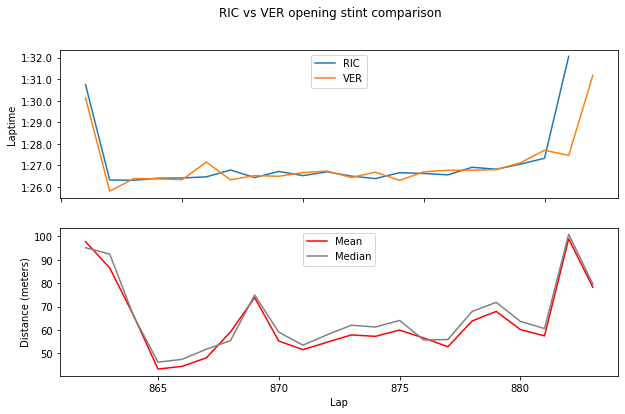

In [90]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots(2)
fig.suptitle(f"{driver1} vs {driver2} opening stint comparison")

ax[0].plot(laps_driver1['RaceLapNumber'], laps_driver1['LapTime'], label=driver1)
ax[0].plot(laps_driver2['RaceLapNumber'], laps_driver2['LapTime'], label=driver2)
ax[0].set(ylabel='Laptime', xlabel='Lap')
ax[0].legend(loc="upper center")

ax[1].plot(summarized_distance_driver1_driver2['Lap'], summarized_distance_driver1_driver2['Mean'], label='Mean', color='red')
ax[1].plot(summarized_distance_driver1_driver2['Lap'], summarized_distance_driver1_driver2['Median'], label='Median', color='grey')
ax[1].set(ylabel='Distance (meters)', xlabel='Lap')
ax[1].legend(loc="upper center")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()

In [91]:
# Get lap data
lap_telemetry_driver1 = laps_driver1.loc[laps_driver1['RaceLapNumber']==4].get_car_data().add_distance()
lap_telemetry_driver2 = laps_driver2.loc[laps_driver2['RaceLapNumber']==4].get_car_data().add_distance()

distance_lap3 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==3]
distance_lap4 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==4]
distance_lap5 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==5]
distance_lap6 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==6]

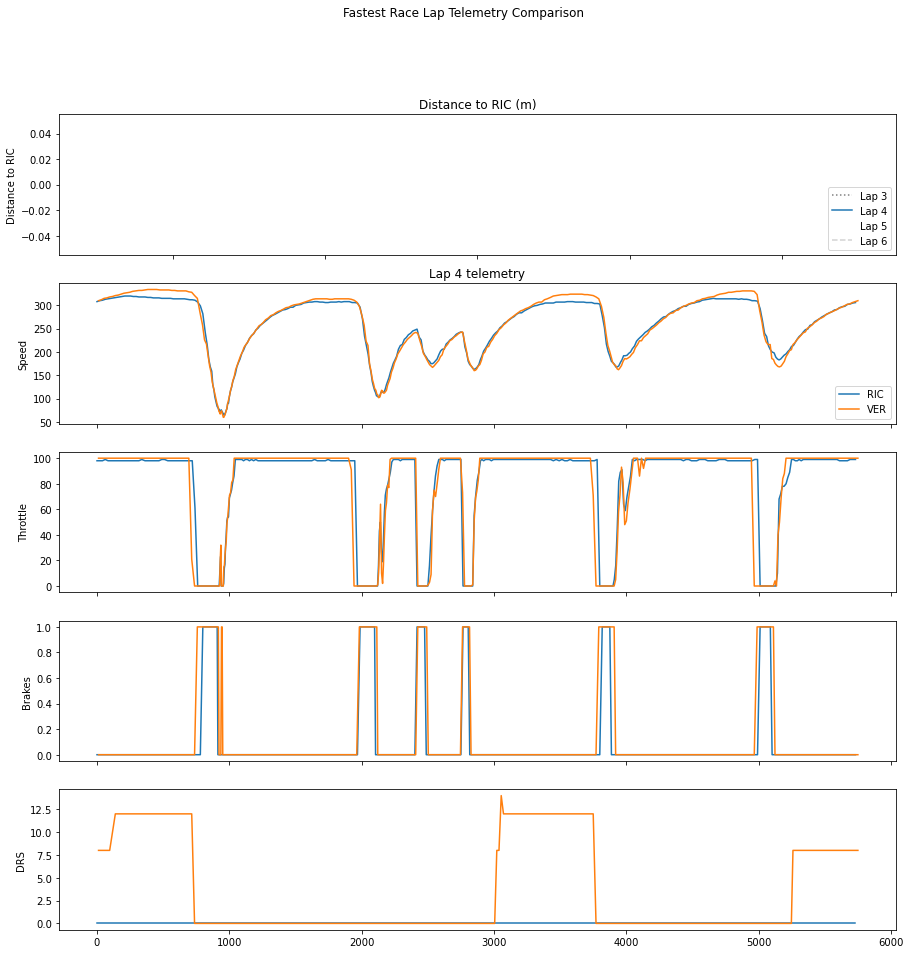

In [92]:
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [15, 15]

fig, ax = plt.subplots(5)
fig.suptitle("Fastest Race Lap Telemetry Comparison")

ax[0].title.set_text(f"Distance to {driver1} (m)")
ax[0].plot(distance_lap3['Distance'], distance_lap3['DistanceToDriverAhead'], label='Lap 3', linestyle='dotted', color='grey')
ax[0].plot(distance_lap4['Distance'], distance_lap4['DistanceToDriverAhead'], label='Lap 4')
ax[0].plot(distance_lap5['Distance'], distance_lap5['DistanceToDriverAhead'], label='Lap 5', linestyle='dotted', color='white')
ax[0].plot(distance_lap6['Distance'], distance_lap6['DistanceToDriverAhead'], label='Lap 6', linestyle='dashed', color='lightgrey')
ax[0].legend(loc="lower right")
ax[0].set(ylabel=f'Distance to {driver1}')

ax[1].title.set_text("Lap 4 telemetry")
ax[1].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Speed'], label=driver1)
ax[1].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Speed'], label=driver2)
ax[1].set(ylabel='Speed')
ax[1].legend(loc="lower right")

ax[2].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Throttle'], label=driver1)
ax[2].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Throttle'], label=driver2)
ax[2].set(ylabel='Throttle')

ax[3].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Brake'], label=driver1)
ax[3].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Brake'], label=driver2)
ax[3].set(ylabel='Brakes')

ax[4].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['DRS'], label=driver1)
ax[4].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['DRS'], label=driver2)
ax[4].set(ylabel='DRS')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

plt.show()